In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.covariance import ledoit_wolf
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

Formatting

In [2]:
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
from nilearn.connectome import ConnectivityMeasure
from sklearn.decomposition import PCA
sns.set()
sns.set_context("talk", font_scale = 1.5)
sns.set_style('whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [10, 10]

Load subset of TEP Data (Full dataset is too large to host on github, but can be found here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1)

In [3]:
with open('Data.pickle', 'rb') as handle:
    Data = pickle.load(handle)

Extract simulation runs and corresponding fault number. Also compute the covariance matrix using the Ledoit-Wolf shrinkage operator to obtain a better estimate of the true covariance matrix.

In [4]:
datas = []
Covs = []
for j in tqdm(range(21)):
    corrs = []
    baseline = Data[Data["faultNumber"] == j]
    for i in range(20):
        baseline1 = baseline[baseline["simulationRun"]==i+1]
        baseline1 = baseline1.iloc[:,3::]
        datas.append(np.asarray(baseline1))
        Wcov = ledoit_wolf(np.asarray(baseline1))[0]
        Covs.append(Wcov)        

  0%|          | 0/21 [00:00<?, ?it/s]

Define matrix operations

In [5]:
def logarithm(cov):
    d, V = np.linalg.eigh(cov)
    D = np.diag(np.log(d))
    logcov = np.dot(np.dot(V, D), V.T)
    return logcov

def sqrroot(cov):
    d, V = np.linalg.eigh(cov)
    D = np.diag(np.sqrt(d))
    sqrroot = np.dot(np.dot(V, D), V.T)
    return sqrroot

def expstep(cov,step):
    d, V = np.linalg.eigh(cov)
    D = np.diag(np.exp(d*step))
    expstep = np.dot(np.dot(V, D), V.T)
    return expstep

def mat_op(operation,d,V):
    return np.dot(V*operation(d),V.T)

Compute the Frechet Mean $\bar{\mathbf{P}}$. Here we use gradient descent to minimze the norm of the covariant derivative on the tangent space at the geometric mean.

Text(0, 0.5, 'Loss')

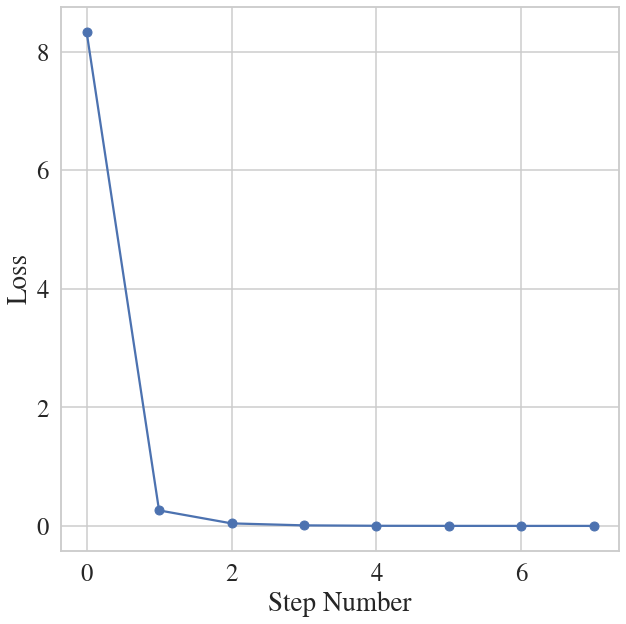

In [6]:
#Initialize the Matrix Mean:
Covs = np.array(Covs)
geomean = np.mean(Covs,axis = 0)

#Initialize the gradient descent step size and loss:
step = 1
norm_old = np.inf

#Set tolerance:
tol = 1e-8
norms = []

for n in range(100):

    #Compute the gradient
    geo_eval,geo_evec = np.linalg.eigh(geomean)
    geomean_inv_sqrt = mat_op(np.sqrt,1. / geo_eval,geo_evec)
    
    #Project matrices to tangent space and compute mean and norm:
    mats= [geomean_inv_sqrt.dot(cov).dot(geomean_inv_sqrt) for cov in Covs]
    log_mats = [logarithm(mat) for mat in mats]
    meanlog = np.mean(log_mats,axis = 0)
    norm = np.linalg.norm(meanlog)

    #Take step along identified geodesic to minimize loss:
    geomean_sqrt = sqrroot(geomean)
    geomean = geomean_sqrt.dot(expstep(meanlog,step)).dot(geomean_sqrt)

    # Update the norm and the step size
    if norm < norm_old:
        norm_old = norm

    elif norm > norm_old:
        step = step / 2.
        norm = norm_old

    if tol is not None and norm / geomean.size < tol:
        break
        
    norms.append(norm)
    
plt.plot(norms,'o-')

plt.xlabel("Step Number")

plt.ylabel("Loss")

Project the data to the corresponding tangent space centered at $\bar{\mathbf{P}}$.

In [7]:
geo_eval,geo_evec = np.linalg.eigh(geomean)

geomean_inv_sqrt = mat_op(np.sqrt,1. / geo_eval,geo_evec)

def T_Project(geomean_inv_sqrt,cov):
    newmat = geomean_inv_sqrt.dot(cov).dot(geomean_inv_sqrt)
    T_cov = logarithm(newmat)
    return T_cov

T_covs = [T_Project(geomean_inv_sqrt,cov) for cov in Covs]

flat_covs = [np.ndarray.flatten(T_cov) for T_cov in T_covs]

Perform PCA on the tangent space data (i.e. Principal Geodesic Analysis)

Text(0, 0.5, 'Principal Component 2')

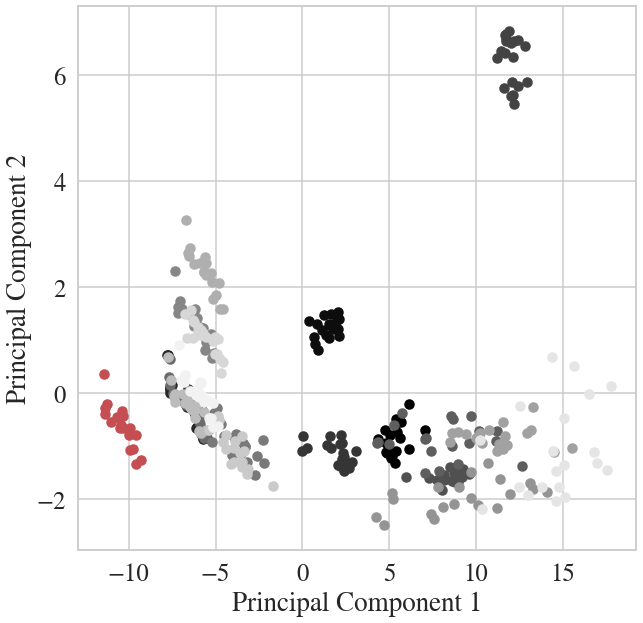

In [8]:
pca = PCA()
X = pca.fit_transform(flat_covs)

colors = cm.gray(np.linspace(0, 1, 20))

for i,c in zip(np.arange(1,20,1),colors):
    plt.scatter(X[i*20:(i+1)*20,0],X[i*20:(i+1)*20,1],color = c)

plt.scatter(X[0*20:(0+1)*20,0],X[0*20:(0+1)*20,1],c = 'r')    

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Perform linear classification in the tangent space and plot normalized confusion matrix

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15'),
 Text(16, 0, '16'),
 Text(17, 0, '17'),
 Text(18, 0, '18'),
 Text(19, 0, '19'),
 Text(20, 0, '20')]

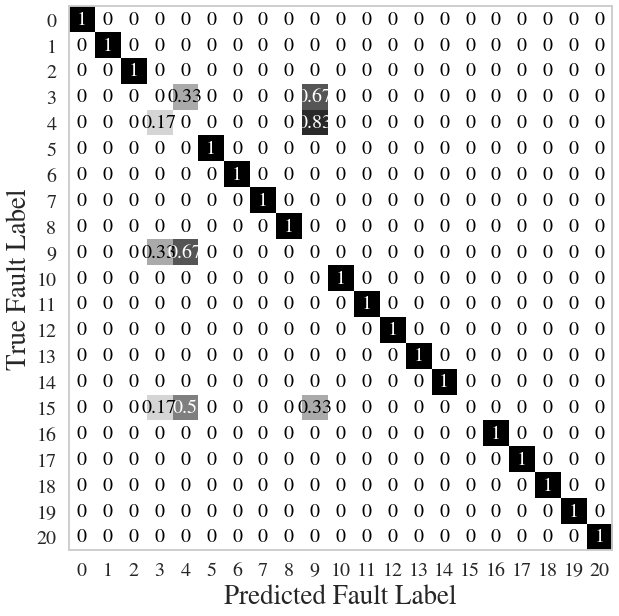

In [9]:
label = []
for i in range(21):
    label.append(np.zeros(20)+i)
    
label = np.hstack(label)

X_train, X_test, y_train, y_test = train_test_split(flat_covs, label, test_size=0.30, stratify = label)

mdl = linear_model.RidgeClassifier()
mdl.fit(X_train,y_train)

plot_confusion_matrix(mdl, X_test, y_test, normalize = 'true',cmap = 'gray_r', colorbar = False)
plt.grid(False)
plt.ylabel("True Fault Label")
plt.xlabel("Predicted Fault Label")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.gca().set_yticklabels([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.gca().set_xticklabels([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

Perform similar analysis, but ignore data geometry.

Text(0, 0.5, 'Principal Component 2')

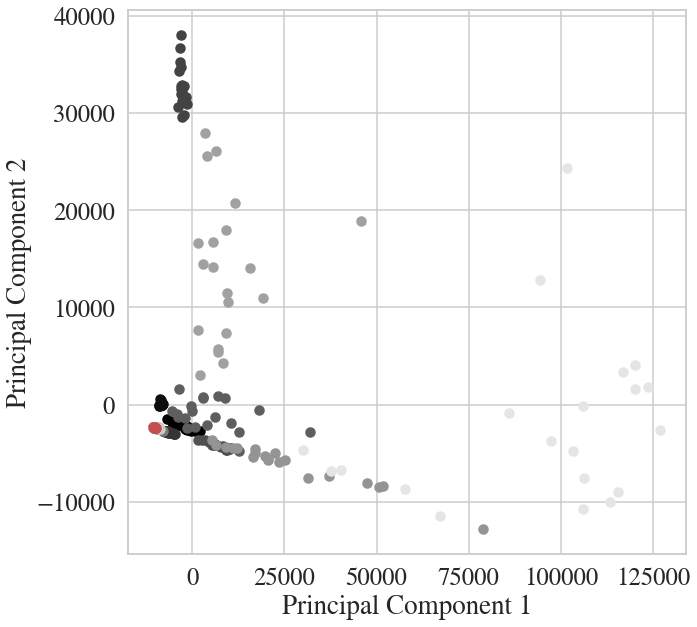

In [10]:
flat_covs = [np.ndarray.flatten(cov) for cov in Covs]

X = pca.fit_transform(flat_covs)

colors = cm.gray(np.linspace(0, 1, 20))

for i,c in zip(np.arange(1,20,1),colors):
    plt.scatter(X[i*20:(i+1)*20,0],X[i*20:(i+1)*20,1],color = c)

plt.scatter(X[0*20:(0+1)*20,0],X[0*20:(0+1)*20,1],c = 'r')    

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Classification without considering data geometry.

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15'),
 Text(16, 0, '16'),
 Text(17, 0, '17'),
 Text(18, 0, '18'),
 Text(19, 0, '19'),
 Text(20, 0, '20')]

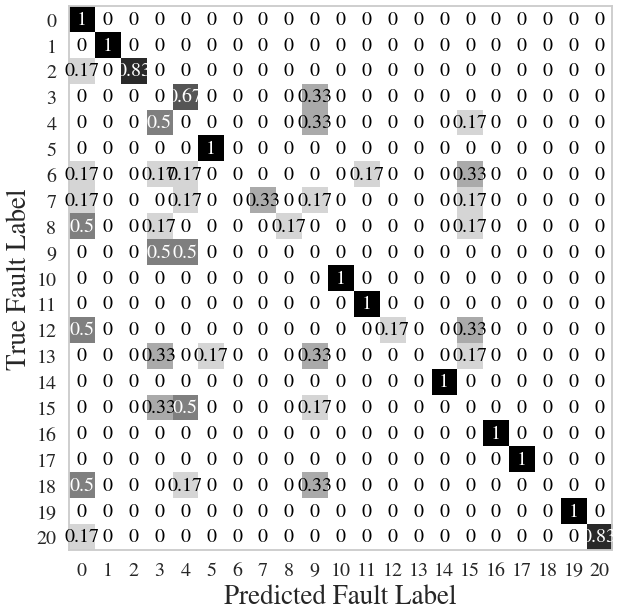

In [11]:
label = []
for i in range(21):
    label.append(np.zeros(20)+i)
    
label = np.hstack(label)

X_train, X_test, y_train, y_test = train_test_split(flat_covs, label, test_size=0.30, stratify = label)

mdl = linear_model.RidgeClassifier()
mdl.fit(X_train,y_train)

plot_confusion_matrix(mdl, X_test, y_test, normalize = 'true',cmap = 'gray_r', colorbar = False)
plt.grid(False)
plt.ylabel("True Fault Label")
plt.xlabel("Predicted Fault Label")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.gca().set_yticklabels([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.gca().set_xticklabels([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])